# Phase 1 Collection (11/04/2023 - 31/05/2023)

During phase 1 collection, 2 NDIR CO2 sensors (model: Sensiron SCD30) were used to sense the CO2 levels within the glass container. Both sensor modules are equipped with temperature and humidity sensors that allows them to quantify exactly how hot and humid the inside of the container is.

## Data Analysis

The data collected from this has several observed patterns:

\<We also want to add data visualisations here about these key observed patterns\>

1. **Daily:** Temperatures will rise accordingly based on how sunny that day is. The highest temperature reached on any given day is ___. The temperature required for decomposition of PolyTerra PLA is stated by the manufacturer to be ___. 
2. **Daily:** Humidity will be lowered in reverse proportion to the temperature, as the water ___ (does the water condensate off?). 
3. **Overall Trend:** There was no observed increase in CO2 throughout the experimentation period

Weight analysis: \<To be done\>

\<Add photos here of the probably decomposed plastics?\>

As such, we conclude that during phase 1, \<conclusion here\> PLA decomposition did/did not occur within the glass envelope.

## Process 1: ingestion of data

This process phase ingests and cleans multiple CSV files as data into a pandas array

In [2]:
import pandas as pd
import os
import seaborn as sns

In [3]:
# ingest data
co2_directory = 'CO2'
li_co2 = []

for filename in os.listdir(co2_directory):
    f = os.path.join(co2_directory, filename)
    # checking if it is a file
    if os.path.isfile(f) and filename[-3:] == 'csv':
        li_co2.append(pd.read_csv(f, parse_dates=[3], encoding='utf-8'))

frame_co2 = pd.concat(li_co2, axis=0, ignore_index=True)

hum_directory = 'Humidity'
li_hum = []

for filename in os.listdir(hum_directory):
    f = os.path.join(hum_directory, filename)
    # checking if it is a file
    if os.path.isfile(f) and filename[-3:] == 'csv':
        li_hum.append(pd.read_csv(f, parse_dates=[3], encoding='utf-8'))

frame_hum = pd.concat(li_hum, axis=0, ignore_index=True)

temp_directory = 'Temperature'
li_temp = []

for filename in os.listdir(temp_directory):
    f = os.path.join(temp_directory, filename)
    # checking if it is a file
    if os.path.isfile(f) and filename[-3:] == 'csv':
        li_temp.append(pd.read_csv(f, parse_dates=[3], encoding='utf-8'))

frame_temp = pd.concat(li_temp, axis=0, ignore_index=True)

# clean data (strip metadata)
frame_co2 = frame_co2.drop(columns=['id', 'feed_id', 'lat', 'lon', 'ele'])
frame_hum = frame_hum.drop(columns=['id', 'feed_id', 'lat', 'lon', 'ele'])
frame_temp = frame_temp.drop(columns=['id', 'feed_id', 'lat', 'lon', 'ele'])

# localize the timezones
frame_co2['created_at'] = frame_co2['created_at'].dt.tz_convert('Asia/Singapore')
frame_hum['created_at'] = frame_hum['created_at'].dt.tz_convert('Asia/Singapore')
frame_temp['created_at'] = frame_temp['created_at'].dt.tz_convert('Asia/Singapore')

# make the datetime the index and dedupe the overlapping times
frame_co2 = frame_co2.set_index('created_at').drop_duplicates()
frame_hum = frame_hum.set_index('created_at').drop_duplicates()
frame_temp = frame_temp.set_index('created_at').drop_duplicates()


## Process 2: datetime processing

The dates and times have to be processed to be normalized, 5 minute intervals in order to facilitate data correlation between the 3 types of data. This resultant data can be pickled and cached on disk for rapid re-computation when tweaking the visualization algos.

In [4]:
# combine all into one big dataframe
frame_co2 = frame_co2.rename(columns = {'value':'co2'})
frame_temp = frame_temp.rename(columns = {'value':'temp'})
frame_hum = frame_hum.rename(columns = {'value':'hum'})

frame_final = pd.merge(frame_co2, frame_hum, how='outer', on='created_at', validate='1:1')
frame_final = pd.merge(frame_final, frame_temp, how='outer', on='created_at', validate='1:1')

frame_final = frame_final.sort_index().reset_index()

# i think checking if the next datum is within the same minute of the first datum is enough to consider those data a singular reading

# cache a local copy of the index and hold it
# base_index = 0

# for idx, row in frame_final.iterrows():
#     if base_index == 0:
#         base_index = idx
#         # print(base_index)
#     base_index = 0

# a vectorized version could be to take diffs of one entry to its previous entry, tag it and combine it based on tagging
frame_final['group_with'] = frame_final['created_at'].diff() < pd.Timedelta(seconds=10)
# frame_final.to_csv('debug.csv') # this is just for debug to see what the data looks like rn

# create new dataframe based on shape of the original, and fill it up with data
pd.DataFrame()

# for row in frame_final.itertuples():
#     # check if row already has all data, sometimes this does happen where one row has 2 or even 3 parameters already in
#     print(row)

# Removes the initial rows where only temperature is being recorded, as well as the last few rows where the True/False falls apart
frame_final_cleaved = frame_final[501:35246]



In [5]:
# Split all individual parameter dataframes using the cleaved dataframe, drop any rows that have NaN
f2_co2 = frame_final_cleaved[['created_at', 'co2']].copy().dropna(axis=0, how='any')
f2_hum = frame_final_cleaved[['created_at', 'hum']].copy().dropna(axis=0, how='any')
f2_temp = frame_final_cleaved[['created_at', 'temp']].copy().dropna(axis=0, how='any')

# Use Pandas merge_asof which can set the tolerance based on a given parameter
# Use Timedelta with temperature as the basis ()
f2 = pd.merge_asof(f2_temp, f2_hum, on='created_at', tolerance=pd.Timedelta(seconds=10), direction='forward')
f2 = pd.merge_asof(f2, f2_co2, on='created_at', tolerance=pd.Timedelta(seconds=10), direction='forward')

frame_flattened = f2[['created_at', 'co2', 'hum', 'temp']]

# # Check all data
# for row in frame_flattened.itertuples():
#     print(row)

c:\Users\jaink2\AppData\Local\miniconda3\envs\corn\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


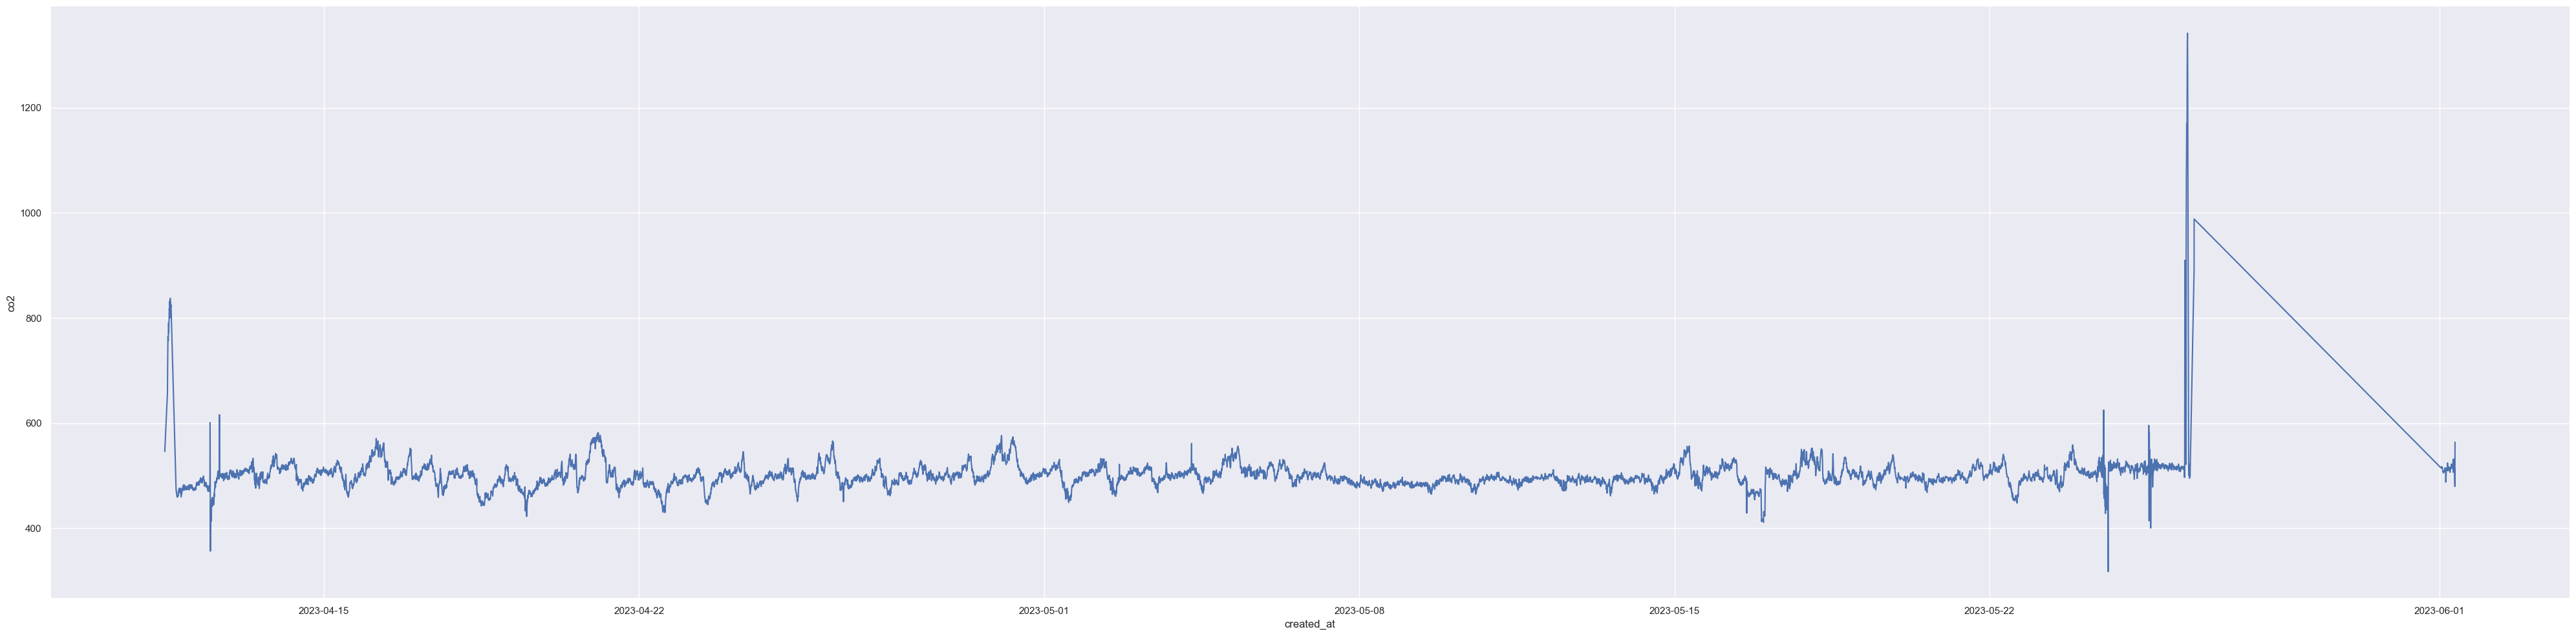

In [25]:
# Data visualisation setup
sns.set()
sns.set_theme()

# Convert from Wide frame to Long frame for seaborn usage
long_frame = frame_flattened.melt(id_vars=['created_at'], value_vars=['co2', 'hum', 'temp'])

# sns.relplot(data=long_frame, x='created_at', y='value', hue='variable',
#             kind='line', height=10, aspect=4)

sns.relplot(data=frame_flattened, x='created_at', y='co2',
            kind='line', height=10, aspect=4)
# long_frame